# Solve 1D electroconvection using PINN


reference code: https://github.com/nanditadoloi/PINN.git
reference paper: https://arxiv.org/abs/2006.14050


In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import numpy as np
import math

from torch.optim.lr_scheduler import LinearLR

In [2]:
# We consider Net as our solution u_theta(x)

class Net(nn.Module):
    def __init__(self, num_layers=3, neuron=3):
        super(Net, self).__init__()
        N_input = 1
        N_output = 2
        
        # Define a list to hold the hidden layers
        self.hidden_layers = nn.ModuleList([
            nn.Linear(N_input, neuron) if i == 0 else nn.Linear(neuron, neuron)
            for i in range(num_layers)
        ])
        
        self.output_layer = nn.Linear(neuron, N_output)

    def forward(self, x):
        inputs = x
        # Loop through the hidden layers
        for layer in self.hidden_layers:
            inputs = torch.sigmoid(layer(inputs))
        
        output = self.output_layer(inputs)
        return output


In [3]:
### (2) Model
lr=0.01
net = Net()
net = net.to(device)
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters(),lr)


# Define the scheduler
scheduler = LinearLR(optimizer, start_factor=1,end_factor=0.1, total_iters = 50000) 

In [4]:
## PDE as loss function. Thus would use the network which we call as u_theta
def f(x, net):
    C = net(x)[:,0]
    phi=net(x)[:,1]
    C = C.reshape(C.numel(),1)
    phi=phi.reshape(C.numel(),1)
 
  
    d_phi_dx = torch.autograd.grad(phi.sum(), x, create_graph=True)[0]
    d2_phi_dx2 = torch.autograd.grad(d_phi_dx.sum(), x, create_graph=True)[0]
    CdPhi=C*d_phi_dx
    d_CdPhi_dx= torch.autograd.grad(CdPhi.sum(), x, create_graph=True)[0]
    
    Q=10
    pde_C = -d_CdPhi_dx
    pde_phi=d2_phi_dx2+Q*C
  
    return pde_C, pde_phi
def bc_f(x, net):
    C = net(x)[0]
    phi=net(x)[1]
 
    d_phi_dx = torch.autograd.grad(phi.sum(), x, create_graph=True)[0]
    CdPhi=C*d_phi_dx
    d_CdPhi_dx= torch.autograd.grad(CdPhi.sum(), x, create_graph=True)[0]
    
    bc = -d_CdPhi_dx

    return bc
def exact_C(x):
    a=0.74412
    b=0.0055371
    Q=10.0
    C=(a/Q)*np.power(x+b,-0.5)
    return C
def exact_E(x):
    a=0.74412
    b=0.0055371
    Q=10.0
    E=2.0*a*np.power(x+b,0.5)
    return E

# Data generation

In [5]:
x_Lbc = torch.tensor([0.0])
x_Rbc = torch.tensor([1.0])
x_Rbc = torch.tensor([1.0], requires_grad=True)
# compute u based on BC
C_Lbc = torch.tensor([1.0])
C_Rbc = torch.tensor([0.0])
phi_Lbc = torch.tensor([1.0])
phi_Rbc = torch.tensor([0.0])
NT_int=300
x_collocation = np.random.uniform(low=0.0, high=1.0, size=(NT_int,1))

# Training

In [ ]:
### (3) Training / Fitting
iterations = 100000
previous_validation_loss = 99999999.0
losses = []  # Empty list to store loss values
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on left boundary conditions

    net_Lbc_out = net(x_Lbc).reshape(1,2) # output of C(x),phi(x)
    mse_Lbc = mse_cost_function(net_Lbc_out[:,0], C_Lbc)+mse_cost_function(net_Lbc_out[:,1], phi_Lbc)
    
    # Loss based on right boundary conditions
    net_Rbc_out = net(x_Rbc).reshape(1,2) # output of C(x)
    bc= bc_f(x_Rbc, net)
    mse_Rbc = mse_cost_function(bc, C_Rbc)+ mse_cost_function(net_Rbc_out[:,1], phi_Rbc)
    

    
    # Loss based on PDE

    all_zeros = np.zeros((NT_int,1))
    
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)

    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)

    f_C, f_phi = f(pt_x_collocation, net) # output of f(x)
    
    
    mse_f_C = mse_cost_function(f_C, pt_all_zeros)#
    mse_f_phi = mse_cost_function(f_phi, pt_all_zeros)
    
    # Combining the loss functions
    loss = mse_f_C+mse_f_phi +mse_Lbc+mse_Rbc
    
    
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() 
    scheduler.step()
    lr=optimizer.param_groups[0]['lr']
    losses.append(loss.detach().numpy())
    
    with torch.autograd.no_grad(): 
    	if(epoch%500==0):
            print(epoch,"Traning Loss:",loss.data, "LR:",lr)
    if(loss.detach().numpy()<0.0001):
        break

In [ ]:
#torch.save(net, "model_1Dec_linschLR_300_ln33_2.pt")

# Testing

In [ ]:
#testing
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
#ax = fig.gca(projection='3d')


x=np.arange(0,1,0.001)
# xe=np.arange(0,1,0.02).reshape(len(x), 1)
# print(xe.shape)

pt_x = torch.from_numpy(x).float().reshape(len(x), 1)
pt_x.requires_grad = True 
# xx=Variable(torch.from_numpy(xe).float(), requires_grad=True).to(device)
pt_out = net(pt_x)
#print(pt_out)
C=pt_out[:,0].detach().numpy()
phi=pt_out[:,1]
# Compute the derivative dphi/dx for each element in phi
d_phi_dx = torch.autograd.grad(phi.sum(), pt_x, create_graph=True)[0]

# Calculate E = -dphi/dx
E = -d_phi_dx.detach().numpy().squeeze()  # Ensure the same shape as x

ex_c = exact_C(x)
ex_E = exact_E(x)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x, C, linestyle='-', label='predicted_C')
plt.plot(x, ex_c, linestyle='--', label='exact_C')
plt.plot(x, E, linestyle='-', label='predicted_E')
plt.plot(x, ex_E, linestyle='--', label='exact_E')
plt.xlabel('x')

plt.legend()
plt.grid(True)
plt.show()
plt.plot(losses)
plt.yscale('log')

# load pretrained model

<Figure size 640x480 with 0 Axes>

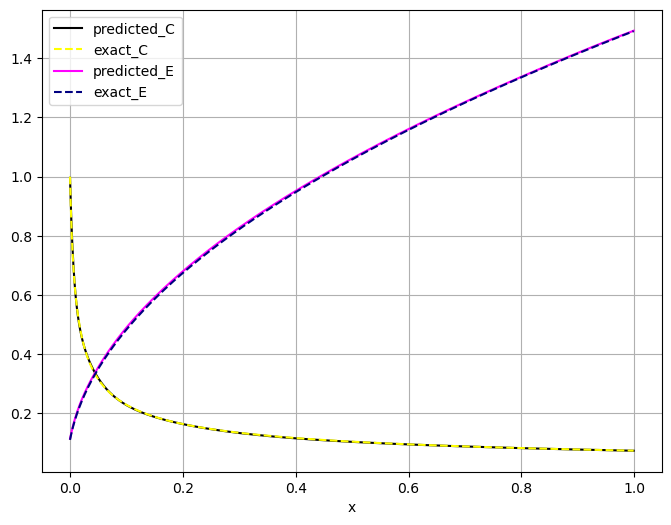

NameError: name 'losses' is not defined

In [6]:
net=torch.load("model_1Dec_linschLR_300_ln33_.pt")
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
#ax = fig.gca(projection='3d')


x=np.arange(0,1,0.001)
# xe=np.arange(0,1,0.02).reshape(len(x), 1)
# print(xe.shape)

pt_x = torch.from_numpy(x).float().reshape(len(x), 1)
pt_x.requires_grad = True 
# xx=Variable(torch.from_numpy(xe).float(), requires_grad=True).to(device)
pt_out = net(pt_x)
#print(pt_out)
C=pt_out[:,0].detach().numpy()
phi=pt_out[:,1]
# Compute the derivative dphi/dx for each element in phi
d_phi_dx = torch.autograd.grad(phi.sum(), pt_x, create_graph=True)[0]

# Calculate E = -dphi/dx
E = -d_phi_dx.detach().numpy().squeeze()  # Ensure the same shape as x

ex_c = exact_C(x)
ex_E = exact_E(x)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x, C,  color='black', label='predicted_C')
plt.plot(x, ex_c, linestyle='--', color='yellow',label='exact_C')
plt.plot(x, E, color='magenta', label='predicted_E')
plt.plot(x, ex_E, color='navy',linestyle='--', label='exact_E')
plt.xlabel('x')

plt.legend()
plt.grid(True)
plt.show()
plt.plot(losses)
plt.yscale('log')